In [2]:
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import importlib

import json
import logging
import pickle
import random
import subprocess
from collections import namedtuple
from datetime import datetime
from pathlib import Path
from threading import Event
from time import time
from typing import List, Tuple, Dict

import pandas as pd

import uuid

import events as e
import settings as s

s.AGENT_COLORS = 4 * ['blue']

from agents import Agent, SequentialAgentBackend
from items import Coin, Explosion, Bomb

from agent_code.large_agent.callbacks import state_to_features, ACTION_MAP, ACTION_MAP_INV
import matplotlib.pyplot as plt

import pygame

from events import *

In [2]:
class EvalWorld:
    def __init__(self, agents):
        self.colors = list(s.AGENT_COLORS)

        self.round = 0
        self.round_statistics = {}

        self.running = False

        self.rng = np.random.default_rng(1234)
        self.setup_agents(agents)

    def add_agent(self, agent_dir, name, train=False):
        assert len(self.agents) < s.MAX_AGENTS

        # if self.args.single_process:
        backend = SequentialAgentBackend(train, name, agent_dir)
        # else:
        # backend = ProcessAgentBackend(train, name, agent_dir)
        backend.start()

        color = self.colors.pop()
        agent = Agent(name, agent_dir, name, train, backend, color, color)
        self.agents.append(agent)

    def setup_agents(self, agents):
        # Add specified agents and start their subprocesses
        self.agents = []
        for agent_dir, train in agents:
            if list([d for d, t in agents]).count(agent_dir) > 1:
                name = agent_dir + '_' + str(list([a.code_name for a in self.agents]).count(agent_dir))
            else:
                name = agent_dir
            self.add_agent(agent_dir, name, train=train)

    def build_arena(self, coin_positions, agent_positions):
        # Bookkeeping
        self.round = -1
        self.step = -1
        self.user_input = None
        self.bombs = []
        self.explosions = []

        WALL = -1
        FREE = 0
        CRATE = 1
        arena = np.zeros((s.COLS, s.ROWS), int)

        # Walls
        arena[:1, :] = WALL
        arena[-1:, :] = WALL
        arena[:, :1] = WALL
        arena[:, -1:] = WALL
        for x in range(s.COLS):
            for y in range(s.ROWS):
                if (x + 1) * (y + 1) % 2 == 1:
                    arena[x, y] = WALL

        # Crates in random locations
        # arena[self.rng.random((s.COLS, s.ROWS)) < CRATE_] = CRATE

        # Place coins at random, at preference under crates
        coins = []
        for x, y in coin_positions:
            coins.append(Coin((x, y), collectable=arena[x, y] == FREE))

        # Reset agents and distribute starting positions
        active_agents = []
        for agent, position in zip(self.agents[:len(agent_positions)], agent_positions):
            active_agents.append(agent)
            agent.x, agent.y = position

        self.arena, self.coins, self.active_agents = arena, coins, active_agents

        for agent in self.active_agents:
            agent.start_round()

    def get_state_for_agent(self, agent: Agent):
        if agent.dead:
            return None

        state = {
            'round': self.round,
            'step': self.step,
            'field': np.array(self.arena),
            'self': agent.get_state(),
            'others': [other.get_state() for other in self.active_agents if other is not agent],
            'bombs': [bomb.get_state() for bomb in self.bombs],
            'coins': [coin.get_state() for coin in self.coins if coin.collectable],
            'user_input': self.user_input,
        }

        explosion_map = np.zeros(self.arena.shape)
        for exp in self.explosions:
            if exp.is_dangerous():
                for (x, y) in exp.blast_coords:
                    explosion_map[x, y] = max(explosion_map[x, y], exp.timer - 1)
        state['explosion_map'] = explosion_map

        return state

In [3]:
class EvalGUI:
    def __init__(self, world):
        self.world = world
        self.screenshot_dir = "../screenshots"

        # Initialize screen
        self.screen = pygame.display.set_mode((s.WIDTH, s.HEIGHT))
        pygame.display.set_caption('BombeRLe')
        icon = pygame.image.load(s.ASSET_DIR / f'bomb_yellow.png')
        pygame.display.set_icon(icon)

        # Background and tiles
        self.background = pygame.Surface((s.WIDTH, s.HEIGHT))
        self.background = self.background.convert()
        self.background.fill((0, 0, 0))
        self.t_wall = pygame.image.load(s.ASSET_DIR / 'brick.png')
        self.t_crate = pygame.image.load(s.ASSET_DIR / 'crate.png')

        self.frame = 0


    def render(self):
        self.screen.blit(self.background, (0, 0))

        # World
        for x in range(self.world.arena.shape[1]):
            for y in range(self.world.arena.shape[0]):
                if self.world.arena[x, y] == -1:
                    self.screen.blit(self.t_wall,
                                     (s.GRID_OFFSET[0] + s.GRID_SIZE * x, s.GRID_OFFSET[1] + s.GRID_SIZE * y))
                if self.world.arena[x, y] == 1:
                    self.screen.blit(self.t_crate,
                                     (s.GRID_OFFSET[0] + s.GRID_SIZE * x, s.GRID_OFFSET[1] + s.GRID_SIZE * y))

        # Items
        for bomb in self.world.bombs:
            bomb.render(self.screen, s.GRID_OFFSET[0] + s.GRID_SIZE * bomb.x, s.GRID_OFFSET[1] + s.GRID_SIZE * bomb.y)
        for coin in self.world.coins:
            if coin.collectable:
                coin.render(self.screen, s.GRID_OFFSET[0] + s.GRID_SIZE * coin.x,
                            s.GRID_OFFSET[1] + s.GRID_SIZE * coin.y)

        # Agents
        for agent in self.world.active_agents:
            agent.render(self.screen, s.GRID_OFFSET[0] + s.GRID_SIZE * agent.x,
                         s.GRID_OFFSET[1] + s.GRID_SIZE * agent.y)

        # Explosions
        for explosion in self.world.explosions:
            explosion.render(self.screen)

        pygame.display.flip()

In [4]:
s.GRID_OFFSET = [0,0]


class ViewGUI:
    def __init__(self, world):
        self.world = world
        self.screenshot_dir = Path("screenshots")

        # Initialize screen
        self.screen = pygame.display.set_mode((s.HEIGHT / 2  - 45, s.HEIGHT / 2))
        pygame.display.set_caption('BombeRLe')
        icon = pygame.image.load(s.ASSET_DIR / f'bomb_yellow.png')
        pygame.display.set_icon(icon)

        # Background and tiles
        self.background = pygame.Surface((s.WIDTH, s.HEIGHT))
        self.background = self.background.convert()
        self.background.fill((0, 0, 0))
        self.t_wall = pygame.image.load(s.ASSET_DIR / 'brick.png')
        self.t_crate = pygame.image.load(s.ASSET_DIR / 'crate.png')

        self.frame = 0


    def render(self, channels, name='output'):
        pygame.display.set_mode((channels.shape[1] * s.GRID_SIZE, channels.shape[2] * s.GRID_SIZE))
        self.screen.blit(self.background, (0, 0))

        pos = (int(channels.shape[1] / 2), int(channels.shape[1] / 2))

        # World
        for x in range(channels.shape[2]):
            for y in range(channels.shape[1]):
                if channels[0, x, y] == 1:
                    self.screen.blit(self.t_wall,
                                     (s.GRID_OFFSET[0] + s.GRID_SIZE * x, s.GRID_OFFSET[1] + s.GRID_SIZE * y))
                if channels[1, x, y] == 1:
                    self.screen.blit(self.t_crate,
                                     (s.GRID_OFFSET[0] + s.GRID_SIZE * x, s.GRID_OFFSET[1] + s.GRID_SIZE * y))
                if channels[2, x, y] == 1:
                    raise NotImplementedError("Can't dispay explosions yet")
                if channels[3, x, y] == 1:
                    self.world.active_agents[1].render(self.screen, s.GRID_OFFSET[0] + s.GRID_SIZE * x,
                         s.GRID_OFFSET[1] + s.GRID_SIZE * y)
                if channels[4, x, y] == 1:
                    self.world.coins[0].render(self.screen, s.GRID_OFFSET[0] + s.GRID_SIZE * x,
                            s.GRID_OFFSET[1] + s.GRID_SIZE * y)

        # Self
        self.world.active_agents[0].render(
            self.screen,
            s.GRID_OFFSET[0] + s.GRID_SIZE * pos[0],
            s.GRID_OFFSET[1] + s.GRID_SIZE * pos[1]
        )

        pygame.display.flip()
        # pygame.image.save(self.screen, str(self.screenshot_dir / f'{uuid.uuid1()}.png'))
        pygame.image.save(self.screen, str(self.screenshot_dir / f'{name}.png'))

In [5]:
def print_state(game_state):
    field = game_state['field'] < 0
    # boxes (box = 1, no box = 0)
    box_map = game_state['field'] == 1
    # coins (coin = 1, no coin = 0)
    coin_map = np.zeros_like(game_state['field'])
    if game_state['coins']:
        coins = np.array(game_state['coins']).T
        coin_map[coins[0], coins[1]] = 1

    # bombs (bomb = 1, no bomb = 0)
    bomb_map = np.zeros_like(game_state['field'])
    if game_state['bombs']:
        bombs = np.array([b[0] for b in game_state['bombs']]).T
        bomb_map[bombs[0], bombs[1]] = 1

    # explosions + fields that are unsafe when one would try to escape in a straight line away from a bomb
    explosion_map = game_state['explosion_map'] > 0

    for (xb, yb), t in game_state['bombs']:
        blast_coords = get_blast_coords(xb, yb, game_state['field'])
        for (i, j) in [(xb + h, yb) for h in range(-3+t, 4-t)] + [(xb, yb + h) for h in range(-3+t, 4-t)]:
            if (i, j) in blast_coords and (0 < i < explosion_map.shape[0]) and (0 < j < explosion_map.shape[1]):
                explosion_map[i, j] = 1

    # others (other agent = 1, else 0)
    others_map = np.zeros_like(game_state['field'])
    others = np.array([o[3] for o in game_state['others']]).T
    if len(others) > 0:
        others_map[others[0], others[1]] = 1
    channels = np.stack([field, box_map, explosion_map, others_map, coin_map], axis=0)

    map = np.full_like(field, ".", dtype=np.str_)
    for i in range(field.shape[0]):
        for j in range(field.shape[1]):
            for k in range(channels.shape[0]):
                if channels[k,i,j] > 0:
                    map[i,j] = "#+*eo"[k]
    pos = game_state['self'][3]
    if map[pos[0], pos[1]] == '*':
        map[pos[0], pos[1]] = "A"
    else:
        map[pos[0], pos[1]] = "@"
    map = map.transpose()
    print("\n".join(["".join(l) for l in map]))
    return map

In [6]:
world = EvalWorld([('large_agent', False), ('random_agent', False), ('random_agent', False), ('random_agent', False)])

In [7]:
world.build_arena([(5,5),(5,6)], [(5,5)])

In [8]:
# world.get_state_for_agent(world.active_agents[0])

In [9]:
m = print_state(world.get_state_for_agent(world.active_agents[0]))

#################
#...............#
#.#.#.#.#.#.#.#.#
#...............#
#.#.#.#.#.#.#.#.#
#....@..........#
#.#.#o#.#.#.#.#.#
#...............#
#.#.#.#.#.#.#.#.#
#...............#
#.#.#.#.#.#.#.#.#
#...............#
#.#.#.#.#.#.#.#.#
#...............#
#.#.#.#.#.#.#.#.#
#...............#
#################


In [11]:
def print_features(channels):
    map = np.full_like(channels[0], ".", dtype=np.str_)
    img_map = np.ones((channels.shape[1], channels.shape[2], 3))
    for i in range(channels.shape[1]):
        for j in range(channels.shape[2]):
            for k in range(channels.shape[0]):
                if channels[k,i,j] > 0:
                    map[i,j] = "#+*eo"[k]
                    img_map[i,j] = [
                        [0,0,0],
                        [.5,.5,0],
                        [1.,0.,0.],
                        [0.,0.,1.],
                        [0.,1.,1.],
                    ][k]
    pos = (int(channels.shape[1] / 2), int(channels.shape[1] / 2))
    if map[pos[0], pos[1]] == '*':
        map[pos[0], pos[1]] = "A"
    else:
        map[pos[0], pos[1]] = "@"
        
    map = map.transpose()
    print("\n".join(["".join(l) for l in map]))
    # plt.imshow(img_map)
    # plt.show()
    return map

In [11]:
m = print_features(state_to_features(world.get_state_for_agent(world.active_agents[0]))[0])

.........
.#.#.#.#.
.........
.#.#.#.#.
....@....
.#.#o#.#.
.........
.#.#.#.#.
.........


In [14]:
agent_pos = (5,5)

baseline_situation = {
    'baseline': {'agent_positions': [agent_pos], 'coin_positions': []},
}

situations = baseline_situation.copy()

In [15]:
for dist in range(1, 5):
    situations.update({
        f'coin top {dist}': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0],agent_pos[1]-dist)]},
        f'coin bottom {dist}': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0],agent_pos[1]+dist)]},
        f'coin right {dist}': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0]+dist,agent_pos[1])]},
        f'coin left {dist}': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0]-dist,agent_pos[1])]},
    })

    situations.update({
            f'enemy top {dist}': {'agent_positions': [agent_pos, (agent_pos[0],agent_pos[1]-dist)], 'coin_positions': []},
            f'enemy bottom {dist}': {'agent_positions': [agent_pos, (agent_pos[0],agent_pos[1]+dist)], 'coin_positions': []},
            f'enemy right {dist}': {'agent_positions': [agent_pos, (agent_pos[0]+dist,agent_pos[1])], 'coin_positions': []},
            f'enemy left {dist}': {'agent_positions': [agent_pos, (agent_pos[0]-dist,agent_pos[1])], 'coin_positions': []},
        })

In [16]:
for situation, situation_kwargs in situations.items():
    print(situation.capitalize() + ":")
    world.build_arena(**situation_kwargs)
    channels = state_to_features(world.get_state_for_agent(world.active_agents[0]))[0]
    gui = ViewGUI(world)
    gui.render(channels, name=situation)
    pygame.display.quit()

Baseline:
Coin top 1:
Coin bottom 1:
Coin right 1:
Coin left 1:
Enemy top 1:
Enemy bottom 1:
Enemy right 1:
Enemy left 1:
Coin top 2:
Coin bottom 2:
Coin right 2:
Coin left 2:
Enemy top 2:
Enemy bottom 2:
Enemy right 2:
Enemy left 2:
Coin top 3:
Coin bottom 3:
Coin right 3:
Coin left 3:
Enemy top 3:
Enemy bottom 3:
Enemy right 3:
Enemy left 3:
Coin top 4:
Coin bottom 4:
Coin right 4:
Coin left 4:
Enemy top 4:
Enemy bottom 4:
Enemy right 4:
Enemy left 4:


## Load models

In [17]:
agent_names = ["hand_crafted_agent", "basic_agent", "lfov_agent", "xxl_lfov_agent"]
models = {}
state_to_features_map = {}

In [18]:
for agent_name in agent_names:
    agent_dir = os.path.join("agent_code", agent_name)

    # Load model weights and functions
    model_weights_path = os.path.join(agent_dir, 'models/model_weights_fine.pth')
    # initialize the model
    model = importlib.import_module(f'agent_code.{agent_name}.networks').AgentNet()
    # load the model weights
    model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
    model.eval()
    models[agent_name] = model
    state_to_features_map[agent_name] = importlib.import_module(f'agent_code.{agent_name}.callbacks').state_to_features

In [19]:
def eval_situation(situations, last_actions=['WAIT']):
    data = {key: [] for key in ['agent', 'prev_action', 'situation', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'BOMB', 'WAIT']}
    for situation, situation_kwargs in situations.items():
        print(situation.capitalize() + "...")
        world.build_arena(**situation_kwargs)
        game_state = world.get_state_for_agent(world.active_agents[0])
            
        for last_action in last_actions:
            for agent_name in agent_names:
                data['situation'].append(situation)
                data['prev_action'].append(last_action)
                data['agent'].append(agent_name)
                if agent_name == "hand_crafted_agent":
                    features, act_map = state_to_features_map[agent_name](game_state, last_action=last_action)
                    act_map_inv = {v: k for k, v in act_map.items()}
                
                    logits = models[agent_name](
                        torch.tensor(features['coin_view'][np.newaxis], dtype=torch.float, requires_grad=False),
                        torch.tensor(features['local_view'][np.newaxis], dtype=torch.float, requires_grad=False),
                        torch.tensor(features['features'][np.newaxis], dtype=torch.float, requires_grad=False),
                    )[0]
                else:
                    channels, features, act_map = state_to_features_map[agent_name](game_state, last_action=last_action)
                    act_map_inv = {v: k for k, v in act_map.items()}
                
                    logits = models[agent_name](
                        torch.tensor(channels[np.newaxis,np.newaxis], dtype=torch.float, requires_grad=False),
                        torch.tensor(features[np.newaxis], dtype=torch.float, requires_grad=False)
                    )[0]
                    # print_features(channels)
                
                    
        
                    
                p = F.softmax(logits, dim=0).detach().numpy()
                action = np.random.choice(range(len(p)), p=p)
                p_string = ", ".join([f"{act_map_inv[ACTION_MAP_INV[i]]}={p[i]:.2f}" for i in range(len(p))])
                for i in range(len(p)):
                    data[act_map_inv[ACTION_MAP_INV[i]]].append(p[i])

    return data

In [20]:
baseline_prev_dep = pd.DataFrame(eval_situation(baseline_situation, last_actions=['WAIT', 'UP', 'DOWN', 'LEFT', 'RIGHT']))
baseline_prev_dep

Baseline...


,agent,prev_action,situation,UP,DOWN,LEFT,RIGHT,BOMB,WAIT
0,hand_crafted_agent,WAIT,baseline,0.195265,0.355017,0.190417,0.258753,0.000501,4.705453e-05
1,basic_agent,WAIT,baseline,0.169716,0.350206,0.162665,0.269736,0.029690,1.798782e-02
2,lfov_agent,WAIT,baseline,0.067047,0.414920,0.141371,0.374620,0.001044,9.985699e-04
3,xxl_lfov_agent,WAIT,baseline,0.072627,0.246475,0.186783,0.493803,0.000244,6.777236e-05
4,hand_crafted_agent,UP,baseline,0.295888,0.152578,0.192728,0.358117,0.000458,2.312178e-04
5,basic_agent,UP,baseline,0.309710,0.149281,0.169841,0.369234,0.000501,1.433776e-03
6,lfov_agent,UP,baseline,0.313854,0.160681,0.083193,0.441859,0.000307,1.067273e-04
7,xxl_lfov_agent,UP,baseline,0.048329,0.125856,0.108497,0.717310,0.000006,6.240326e-07
8,hand_crafted_agent,DOWN,baseline,0.091844,0.471676,0.153158,0.283010,0.000283,2.899368e-05
9,basic_agent,DOWN,baseline,0.046848,0.615319,0.120499,0.216472,0.000204,6.589608e-04


In [21]:
print(baseline_prev_dep.loc[:, baseline_prev_dep.columns != 'situation'].to_latex(float_format="%.2f", index=False, escape=True))

\begin{tabular}{llrrrrrr}
\toprule
agent & prev\_action & UP & DOWN & LEFT & RIGHT & BOMB & WAIT \\
\midrule
hand\_crafted\_agent & WAIT & 0.20 & 0.36 & 0.19 & 0.26 & 0.00 & 0.00 \\
basic\_agent & WAIT & 0.17 & 0.35 & 0.16 & 0.27 & 0.03 & 0.02 \\
lfov\_agent & WAIT & 0.07 & 0.41 & 0.14 & 0.37 & 0.00 & 0.00 \\
xxl\_lfov\_agent & WAIT & 0.07 & 0.25 & 0.19 & 0.49 & 0.00 & 0.00 \\
hand\_crafted\_agent & UP & 0.30 & 0.15 & 0.19 & 0.36 & 0.00 & 0.00 \\
basic\_agent & UP & 0.31 & 0.15 & 0.17 & 0.37 & 0.00 & 0.00 \\
lfov\_agent & UP & 0.31 & 0.16 & 0.08 & 0.44 & 0.00 & 0.00 \\
xxl\_lfov\_agent & UP & 0.05 & 0.13 & 0.11 & 0.72 & 0.00 & 0.00 \\
hand\_crafted\_agent & DOWN & 0.09 & 0.47 & 0.15 & 0.28 & 0.00 & 0.00 \\
basic\_agent & DOWN & 0.05 & 0.62 & 0.12 & 0.22 & 0.00 & 0.00 \\
lfov\_agent & DOWN & 0.01 & 0.60 & 0.04 & 0.35 & 0.00 & 0.00 \\
xxl\_lfov\_agent & DOWN & 0.01 & 0.41 & 0.11 & 0.46 & 0.00 & 0.00 \\
hand\_crafted\_agent & LEFT & 0.19 & 0.33 & 0.33 & 0.14 & 0.00 & 0.00 \\
basic\_agent 

## Moves towards coin

In [22]:
approach_probs = []

for dist in range(1, 5):
    
    coin_situations = {
        f'UP': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0],agent_pos[1]-dist)]},
        f'DOWN': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0],agent_pos[1]+dist)]},
        f'LEFT': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0]-dist,agent_pos[1])]},
        f'RIGHT': {'agent_positions': [agent_pos], 'coin_positions': [(agent_pos[0]+dist,agent_pos[1])]},
    }

    for dir, situation in coin_situations.items():
        coin_dep = pd.DataFrame(eval_situation({dir: situation}, last_actions=['WAIT', 'UP', 'DOWN', 'LEFT', 'RIGHT']))
        coin_dep['approach'] = coin_dep[dir]
        coin_dep['distance'] = np.full((coin_dep.shape[0]), dist)
        approach_probs.append(coin_dep[['agent', 'approach', 'distance']])

Up...
Down...
Left...
Right...
Up...
Down...
Left...
Right...
Up...
Down...
Left...
Right...
Up...
Down...
Left...
Right...


In [23]:
approach_probs_mean = pd.concat(approach_probs).groupby(['agent', 'distance']).mean(numeric_only=True)
approach_probs_sd = pd.concat(approach_probs).groupby(['agent', 'distance']).std(numeric_only=True)

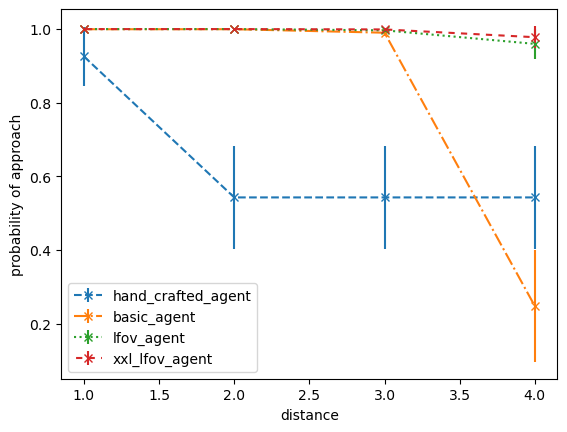

In [24]:
fig = plt.figure()
for i, agent in enumerate(agent_names):
    plt.errorbar(
        x = approach_probs_mean.loc[agent].reset_index()['distance'].to_numpy(),
        y = approach_probs_mean.loc[agent,'approach'].to_numpy(),
        yerr = approach_probs_sd.loc[agent,'approach'].to_numpy(),
        label = agent,
        marker='x',
        linestyle=["--", "-.", ":", (5, (3,3))][i]
    )
plt.ylabel('probability of approach')
plt.xlabel('distance')
_ = plt.legend()

In [26]:
fig.savefig("fig/coin_approach.pdf", dpi=300)

## Moves towards enemy

In [27]:
approach_probs = []

for dist in range(1, 5):
    
    enemy_situations = {
        f'UP': {'agent_positions': [agent_pos, (agent_pos[0],agent_pos[1]-dist)], 'coin_positions': []},
        f'DOWN': {'agent_positions': [agent_pos, (agent_pos[0],agent_pos[1]+dist)], 'coin_positions': []},
        f'RIGHT': {'agent_positions': [agent_pos, (agent_pos[0]-dist,agent_pos[1])], 'coin_positions': []},
        f'LEFT': {'agent_positions': [agent_pos, (agent_pos[0]+dist,agent_pos[1])], 'coin_positions': []},
    }

    for dir, situation in enemy_situations.items():
        enemy_dep = pd.DataFrame(eval_situation({dir: situation}, last_actions=['WAIT', 'UP', 'DOWN', 'LEFT', 'RIGHT']))
        enemy_dep['approach'] = enemy_dep[dir]
        enemy_dep['distance'] = np.full((enemy_dep.shape[0]), dist)
        approach_probs.append(enemy_dep[['agent', 'approach', 'distance', 'BOMB']])

Up...
Down...
Right...
Left...
Up...
Down...
Right...
Left...
Up...
Down...
Right...
Left...
Up...
Down...
Right...
Left...


In [28]:
approach_probs_mean = pd.concat(approach_probs).groupby(['agent', 'distance']).mean(numeric_only=True)
approach_probs_sd = pd.concat(approach_probs).groupby(['agent', 'distance']).std(numeric_only=True)

In [29]:
approach_probs_mean.loc[agent].reset_index()['distance'].to_numpy() + np.linspace(-1, 1, 4)

array([0.        , 1.66666667, 3.33333333, 5.        ])

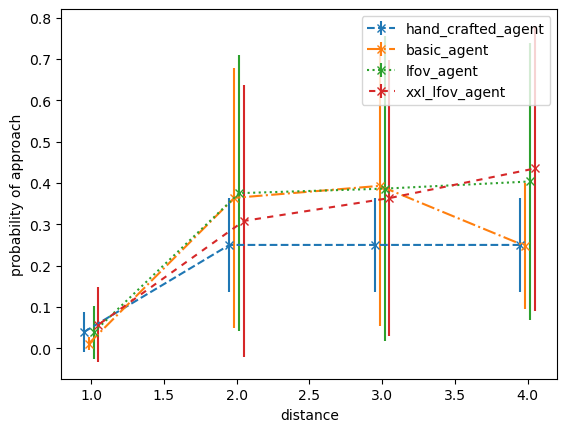

In [31]:
fig = plt.figure()

for i, agent in enumerate(agent_names):
    plt.errorbar(
        x = approach_probs_mean.loc[agent].reset_index()['distance'].to_numpy() + np.linspace(-0.05, 0.05, 4)[i],
        y = approach_probs_mean.loc[agent,'approach'].to_numpy(),
        yerr = approach_probs_sd.loc[agent,'approach'].to_numpy(),
        label = agent,
        marker='x',
        linestyle=["--", "-.", ":", (5, (3,3))][i]
    )
plt.ylabel('probability of approach')
plt.xlabel('distance')
_ = plt.legend()

In [32]:
fig.savefig("fig/enemy_approach.pdf", dpi=300)

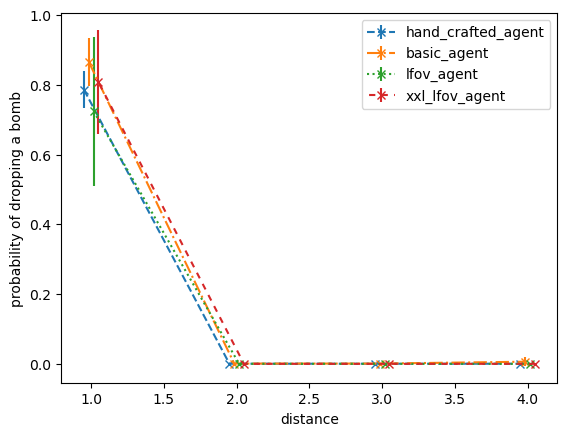

In [33]:
fig = plt.figure()

for i, agent in enumerate(agent_names):
    plt.errorbar(
        x = approach_probs_mean.loc[agent].reset_index()['distance'].to_numpy() + np.linspace(-0.05, 0.05, 4)[i],
        y = approach_probs_mean.loc[agent,'BOMB'].to_numpy(),
        yerr = approach_probs_sd.loc[agent,'BOMB'].to_numpy(),
        label = agent,
        marker='x',
        linestyle=["--", "-.", ":", (5, (3,3))][i]
    )
plt.ylabel('probability of dropping a bomb')
plt.xlabel('distance')
_ = plt.legend()

In [34]:
fig.savefig("fig/enemy_bomb.pdf", dpi=300)

## Visualizing the features

In [ ]:
from torch.utils.data import Dataset


class BombermanDataset(Dataset):
    def __init__(self, states_dir, max_game_step=400, min_reward=1, skip_invalid=False, skip_wait=False):
        self.features = []
        self.actions = []
        self.cum_rewards = []
        self.total_number = 0
        for states_file in os.listdir(states_dir):
            if not states_file.endswith('.pickle'):
                continue
            with open(os.path.join(states_dir, states_file), "rb") as f:
                data = pickle.load(f)
            self.total_number += len(data['game_state'])
            last_round = -1
            running_horizons = []
            running_rewards = []
            running_steps = []
            dropped_bad_bomb = False
            for i in range(len(data['game_state'])-1,-1,-1):
                game_state = data['game_state'][i]
                if last_round != game_state['round']:
                    last_round = game_state['round']
                    running_horizons = []
                    running_rewards = []
                    running_steps = []
                    dropped_bad_bomb = False
        
                running_rewards = [r for j,r in enumerate(running_rewards) if running_horizons[j]>1]
                running_steps = [s for j,s in enumerate(running_steps) if running_horizons[j]>1]
                running_horizons = [h-1 for h in running_horizons if h > 1]
                if game_state['step'] > max_game_step:
                    continue
                # make sure that only a single CRATE_DESTROYED event is present
                events = []
                crate_event_registered = False
                for e in data['events'][i]:
                    if e != CRATE_DESTROYED:
                        events.append(e)
                    elif not crate_event_registered:
                        crate_event_registered = True
                        events.append(e)
                    if e == KILLED_SELF:
                        dropped_bad_bomb = True
                    if e == BOMB_DROPPED:
                        events.append(DROPPED_BAD_BOMB)
                        dropped_bad_bomb = False
                    
                # determine if action should be included in training set
                horizons = [EVENT_HORIZON[e] for e in events]
                rewards = [REWARDS[e] for e in events]
                steps = [game_state['step'] for e in events]
                running_rewards.extend(rewards)
                running_horizons.extend(horizons)
                running_steps.extend(steps)

                if skip_invalid and INVALID_ACTION in data['events'][i]:
                    data['action'][i] = 'WAIT'
                    continue

                
                self.cum_rewards.append(np.sum(np.array(running_rewards) * np.exp(-(np.array(running_steps) - game_state['step']) / alpha)))
                # self.cum_rewards.append(np.sum(running_rewards))

                last_action = None if game_state['step'] == 1 else data['action'][i-1]
                channels, features, act_map = state_to_features(game_state, r=5, last_action=last_action)
                action = ACTION_MAP[act_map[data['action'][i]]]
                self.features.append((
                    torch.tensor(channels[np.newaxis], dtype=torch.float),
                    torch.tensor(features, dtype=torch.float)
                ))
                self.actions.append(action)
        self.cum_rewards = torch.tensor(self.cum_rewards, dtype=torch.float)
        self.actions = torch.tensor(self.actions)

        # adjust for the fact that waiting cannot be invalid
        if skip_wait:
            wait_idxs = (self.actions == ACTION_MAP['WAIT']).nonzero()[:,0].numpy()
            num_keep = int(.25 * len(self.actions))
            np.random.shuffle(wait_idxs)
            rm_idxs = wait_idxs[num_keep:]
            if len(rm_idxs) > 0:
                print(f"Remove {len(rm_idxs)} of WAIT actions.")
                keep_idxs = [i for i in range(len(self.actions)) if i not in rm_idxs]
    
                self.features = [self.features[j] for j in keep_idxs]
                self.actions = self.actions[keep_idxs]
                self.cum_rewards = self.cum_rewards[keep_idxs]
        
        self.n = np.array([np.sum([t == i for t in self.actions]) for i in range(6)])
        self.weights = np.array([1/self.n[t] for t in self.actions])
        self.proportion_selected = len(self.actions)/self.total_number
        print(f"Chose {len(self.actions)} of {self.total_number} actions ({self.proportion_selected*100:.0f}%)")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.actions[idx], self.cum_rewards[idx]

In [39]:
from agent_code.lfov_agent.callbacks import state_to_features

In [46]:
states_dir = "agent_code/data"
states_file =  os.listdir(states_dir)[0]
print(states_file)
if not states_file.endswith('.pickle'):
    print("Wrong file")
with open(os.path.join(states_dir, states_file), "rb") as f:
    data = pickle.load(f)

i = 64

game_state = data['game_state'][i]

channels, features, act_map = state_to_features(game_state, r=5, last_action=None)

ab4686f8-5f6c-11ee-bedc-d880837dcad3.pickle


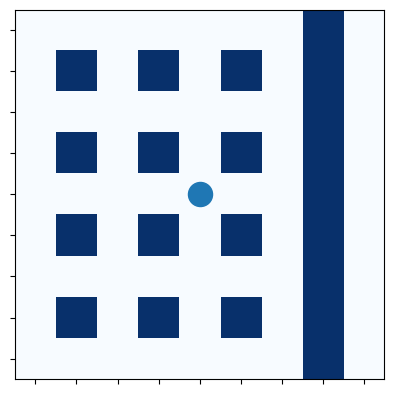

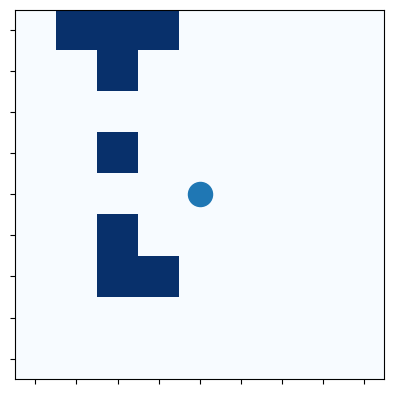

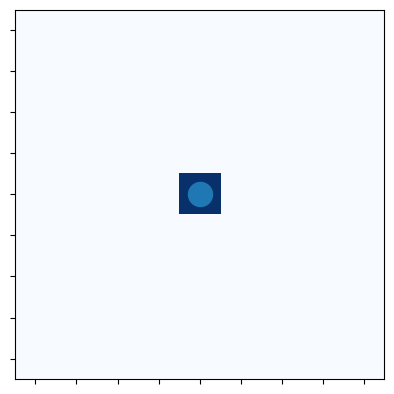

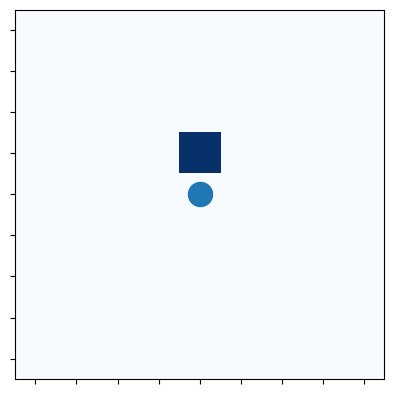

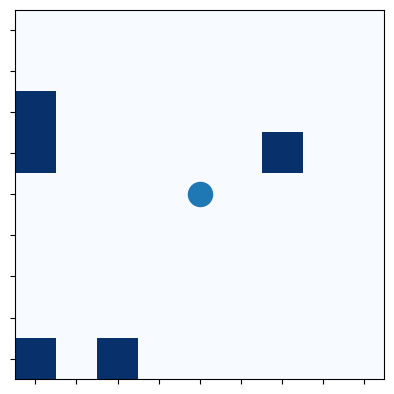

In [63]:
channel_names = ['field', 'crate', 'explosion', 'other', 'coin']
for i in range(channels.shape[0]):
    fig = plt.figure()
    plt.imshow(np.flip(np.flip(channels, axis=1), axis=2)[i].transpose(), cmap='Blues')
    plt.xticks(ticks=range(9), labels=["" for i in range(channels.shape[1])])
    plt.yticks(ticks=range(9), labels=["" for i in range(channels.shape[1])])
    plt.scatter(4, 4, s=300)
    plt.show()
    fig.savefig(f"fig/channel_{channel_names[i]}.pdf", dpi=300)

In [34]:
print_features(np.flip(np.flip(channels, axis=1), axis=2))

.+++...#.
.#+#.#.#.
o......#.
o#+#e#o#.
....A..#.
.#+#.#.#.
..++...#.
.#.#.#.#.
o.o....#.


array([['.', '+', '+', '+', '.', '.', '.', '#', '.'],
       ['.', '#', '+', '#', '.', '#', '.', '#', '.'],
       ['o', '.', '.', '.', '.', '.', '.', '#', '.'],
       ['o', '#', '+', '#', 'e', '#', 'o', '#', '.'],
       ['.', '.', '.', '.', 'A', '.', '.', '#', '.'],
       ['.', '#', '+', '#', '.', '#', '.', '#', '.'],
       ['.', '.', '+', '+', '.', '.', '.', '#', '.'],
       ['.', '#', '.', '#', '.', '#', '.', '#', '.'],
       ['o', '.', 'o', '.', '.', '.', '.', '#', '.']], dtype='<U1')